In [1]:
!pip install de_sim

ERROR: Error while checking for conflicts. Please file an issue on pip's issue tracker: https://github.com/pypa/pip/issues/new
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "/usr/local/lib/python3.7/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent

<!-- :Author: Arthur Goldberg <Arthur.Goldberg@mssm.edu> -->
<!-- :Date: 2020-07-13 -->
<!-- :Copyright: 2020, Karr Lab -->
<!-- :License: MIT -->

# A stochastic epidemic model

<font size="4">
Epidemics occur when infectious diseases spread through a susceptible population.
Models that classify individuals by their infectious state are used to study the dynamics of epidemics.
The simplest approach considers three infectious states:
<br>

* *Susceptible*: a person who can become infected if exposed
* *Infectious*: a person who is infected, and can transmit the infection to a susceptible person
* *Recovered*: a person who has recovered from an infection, and cannot be reinfected

Dynamic analyses of epidemics are called Susceptible, Infectious, or Recovered (SIR) models.
SIR models are described by the initial population of people in each state and the rates at which they transition between states.

![SIR model states and transitions](SIR_Flow_Diagram.svg)
*SIR model states and transitions*

S and I represent the number of individuals in states Susceptible and Infectious, respectively. &beta; and &gamma; are model parameters.

We present a stochastic SIR model that demonstrates the core features of DE-Sim.
The SIR model uses DE-Sim to implement a continuous-time Markov chain model, as described in section 3 of Allen, 2017. Infectious Disease Modelling.

Let's implement and use the SIR model.

![gray_line](gray_horiz_line.svg)

First, define the event messages
</font>

In [2]:
"DE-Sim implementation of an SIR epidemic model"

import enum
import numpy

import de_sim


class StateTransitionType(enum.Enum):
    " State transition types "
    s_to_i = 'Transition from Susceptible to Infectious'
    i_to_r = 'Transition from Infectious to Recovered'


class TransitionMessage(de_sim.EventMessage):
    "Message for all model transitions"
    transition_type: StateTransitionType


MESSAGE_TYPES = [TransitionMessage]

![gray_line](gray_horiz_line.svg)
<font size="4">

Next, define a simulation object. It has these attributes:
<br>
    
* s (int): number of susceptible subjects
* i (int): number of infectious subjects
* N (int): total number of susceptible subjects, a constant
* beta (float): SIR beta parameter
* gamma (float): SIR gamma parameter
* random_state (numpy.random.RandomState): a random state

</font>

In [3]:
class SIR(de_sim.SimulationObject):
    """Implement a Susceptible, Infectious, or Recovered (SIR)
       epidemic model"""
    def __init__(self, name, s, i, N, beta, gamma):
        " Initialize an SIR instance "
        self.s = s
        self.i = i
        self.N = N
        self.beta = beta
        self.gamma = gamma
        self.random_state = numpy.random.RandomState()
        super().__init__(name)

    def init_before_run(self):
        " Send the initial events "
        self.schedule_next_event()

    def schedule_next_event(self):
        " Schedule the next SIR event "
        rates = {'s_to_i': self.beta * self.s * self.i / self.N,
                 'i_to_r': self.gamma * self.i}
        lambda_val = rates['s_to_i'] + rates['i_to_r']
        if lambda_val == 0:
            # no transitions remain
            return
        tau = self.random_state.exponential(1.0/lambda_val)
        prob_s_to_i = rates['s_to_i'] / lambda_val
        if self.random_state.random_sample() < prob_s_to_i:
            self.send_event(tau, self, TransitionMessage(StateTransitionType.s_to_i))
        else:
            self.send_event(tau, self, TransitionMessage(StateTransitionType.i_to_r))

    def handle_state_transition(self, event):
        " Handle an infectious state transition event "
        transition_type = event.message.transition_type
        if transition_type is StateTransitionType.s_to_i:
            self.s -= 1
            self.i += 1
        elif transition_type is StateTransitionType.i_to_r:
            self.i -= 1
        self.schedule_next_event()

    event_handlers = [(TransitionMessage, 'handle_state_transition')]

    # register the message types sent
    messages_sent = MESSAGE_TYPES

In [4]:
from de_sim.checkpoint import AccessCheckpoints, Checkpoint
from de_sim.simulation_checkpoint_object import (AccessStateObjectInterface,
                                                 CheckpointSimulationObject)

class AccessSIRObjectState(AccessStateObjectInterface):
    """ Get the state of the simulation

    Attributes:
        sir (`obj`): an SIR object
        random_state (`numpy.random.RandomState`): a random state
    """

    def __init__(self, sir):
        self.sir = sir
        self.random_state = sir.random_state

    def get_checkpoint_state(self, time):
        """ Get the simulation's state

        Args:
            time (`float`): current time; ignored
        """
        return dict(s=self.sir.s,
                    i=self.sir.i)

    def get_random_state(self):
        " Get the simulation's random state "
        return self.random_state.get_state()

![gray_line](gray_horiz_line.svg)
<font size="4">
The next cell defines code to run the SIR model and visualize its predictions.
</font>

In [5]:
import pandas

class RunSIR(object):

    def __init__(self, checkpoint_dir):
        self.checkpoint_dir = checkpoint_dir

    def simulate(self, recording_period, max_time, **sir_args):
        """ Create and run an SIR simulation

        Args:
            recording_period (`float`): interval between state checkpoints
            max_time (`float`): simulation end time
            sir_args (`dict`): arguments for an SIR object
        """
        # create a simulator
        simulator = de_sim.Simulator()

        # create an SIR instance
        self.sir = sir = SIR(**sir_args)
        simulator.add_object(sir)

        # create a checkpoint simulation object
        access_state_object = AccessSIRObjectState(sir)
        checkpointing_obj = CheckpointSimulationObject('checkpointing_obj',
                                                       recording_period,
                                                       self.checkpoint_dir,
                                                       access_state_object)
        simulator.add_object(checkpointing_obj)

        # initialize simulation, which sends the SIR instance an initial event message
        simulator.initialize()

        # run the simulation
        event_num = simulator.simulate(max_time).num_events

    def last_checkpoint(self):
        """ Get the last checkpoint of the last simulation run

        Returns:
            `Checkpoint`: the last checkpoint of the last simulation run
        """
        access_checkpoints = AccessCheckpoints(self.checkpoint_dir)
        last_checkpoint_time = access_checkpoints.list_checkpoints()[-1]
        return access_checkpoints.get_checkpoint(time=last_checkpoint_time)

    def history_to_dataframe(self):
        fields = ('s', 'i', 'r')
        hist = []
        index = []
        access_checkpoints = AccessCheckpoints(self.checkpoint_dir)
        for checkpoint_time in access_checkpoints.list_checkpoints():
            state = access_checkpoints.get_checkpoint(time=checkpoint_time).state
            state_as_list = [state['s'], state['i'], self.sir.N - state['s'] - state['i']]
            hist.append(dict(zip(fields, state_as_list)))
            index.append(checkpoint_time)
        return pandas.DataFrame(hist)

![gray_line](gray_horiz_line.svg)
<font size="4">
Use the model to view an epidemic's predictions.
We use parameters from Allen (2017), and print and plot the trajectory of a single simulation.
Since the model is stochastic, each run produces a different trajectory.
    </font>

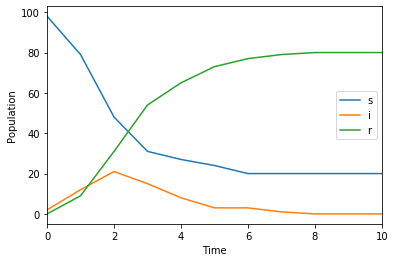

In [6]:
import tempfile

sir_args = dict(name='sir',
                s=98,
                i=2,
                N=100,
                beta=0.3,
                gamma=0.15)
with tempfile.TemporaryDirectory() as tmpdirname:
    run_sir = RunSIR(tmpdirname)
    run_sir.simulate(10, 100, **sir_args)

    # print and plot an epidemic's predicted trajectory
    sir_data_frame = run_sir.history_to_dataframe()
    axes = sir_data_frame.plot()
    axes.set_xlabel("Time")
    rv = axes.set_ylabel("Population")

![gray_line](gray_horiz_line.svg)
<font size="4">
An important prediction generated by the SIR model is the severity of the epidemic, which can be summarized by the fraction of people who became infected.
We run an ensemble of simulations and examine the predicted distribution of severity.
    </font>

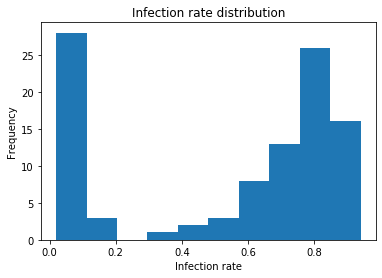

In [7]:
import math

num_sims = 100
infection_rates= []

for _ in range(num_sims):
    with tempfile.TemporaryDirectory() as tmpdirname:
        run_sirs = RunSIR(tmpdirname)
        run_sirs.simulate(recording_period=10, max_time=60, **sir_args)
        # infection rate = infectious + recovered
        # N = s + i + r => i + r = N - s
        final_state = run_sirs.last_checkpoint().state
        N = sir_args['N']
        infection_rate = (N - final_state['s'])/N
        infection_rates.append(infection_rate)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
rv = plt.hist(infection_rates)
ax.set_title('Infection rate distribution')
ax.set_xlabel('Infection rate')
rv = ax.set_ylabel('Frequency')

<font size="4">
As predicted by Allen's (2017) analysis, for the parameters in `sir_args` the infection rate distribution is bimodal. Most of the epidemics infect a majority of the population and a small fraction of them (Allen predicts 25%) burn out and infect only a minority of the population.

</font>

![gray_line](gray_horiz_line.svg)

<font size="4">
The simple model above only touches the surface of epidemic modeling. Many extensions are possible:

* A spatial model with multiple geographic areas: each area would be represented by an instance of SIR.
* An extension of the spatial model that also represents travel between geographic areas
* A model that represents individuals in more states, such as multiple infectious states which distinguish between asymptomatic and symptomatic individuals, with a lower transmission parameter &beta; for symptomatic individuals who would likely isolate while recovering
* A model that can model both small and large populations: it would use the stochastic approach above to integrate small populations and ODEs to integrate large populations. Models and simulators that use multiple integration methods are called *multi-algorithmic*.

We encourage you to experiment with different parameters for this model and build your own models!
    </font>

**References**

Allen, L.J., 2017. A primer on stochastic epidemic models: Formulation, numerical
simulation, and analysis. Infectious Disease Modelling, 2(2), pp.128-142.